# Human Activity Recognition Project

In [603]:
import os
import warnings
import sys 

from glob import glob

import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import sklearn

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 


import pickle
import errno

## Read the individual pickled features and create train and test sets

In [709]:
## Test File

test_df = pd.DataFrame()
in_file = r"/Users/rohankumar/Desktop/BBDC 2019/Data/pickle/test/mean.pickle"
pickle_in = open(in_file,"rb")
test_df = pickle.load(pickle_in)
test_df.head()

features = ['median','min','max','std','variance','mad','rms','iqr','pe']

for feature in features:
    df = pd.DataFrame()
    in_file = r"/Users/rohankumar/Desktop/BBDC 2019/Data/pickle/test/" + feature +".pickle"
    pickle_in = open(in_file,"rb")
    df = pickle.load(pickle_in)
    test_df = pd.merge(test_df, df, left_index=True, right_index=True)
    del(df)
print(test_df.shape)
test_X= test_df


## Train File

train_df = pd.DataFrame()
in_file =  r"/Users/rohankumar/Desktop/BBDC 2019/Data/pickle/train/mean.pickle"
pickle_in = open(in_file,"rb")
train_df = pickle.load(pickle_in)
train_df.head()

features = ['median','min','max','std','variance','mad','rms','iqr','pe']

for feature in features:
    df = pd.DataFrame()
    in_file =  r"/Users/rohankumar/Desktop/BBDC 2019/Data/pickle/train/" + feature +".pickle"
    pickle_in = open(in_file,"rb")
    df = pickle.load(pickle_in)
    df = df.drop([feature+'_activity'], axis=1)
    train_df = pd.merge(train_df, df, left_index=True, right_index=True)
    del(df)
print(train_df.shape)

(1738, 190)
(6401, 201)


In [710]:
train_df.rename(columns={'mean_activity': 'activity'}, inplace=True)
train_df.drop(columns = ['mean_datafile','median_datafile', 'min_datafile', 'max_datafile', 'std_datafile', 'variance_datafile',
                         'mad_datafile', 'rms_datafile', 'iqr_datafile', 'pe_datafile'], inplace=True)
train_df.shape

(6401, 191)

In [711]:
test_df.shape

(1738, 190)

## Exploratory Data Analysis

In [712]:
pd.crosstab(index=train_df['activity'], columns = 'count')

col_0,count
activity,
curve-left-spin-Lfirst,280
curve-left-spin-Rfirst,320
curve-left-step,299
curve-right-spin-Lfirst,301
curve-right-spin-Rfirst,300
curve-right-step,295
jump-one-leg,279
jump-two-leg,280
lateral-shuffle-left,282


### Balanced Dataset
From the below histogam plot we can see that most of the activities except "Lay" are equally balanced across the 
rows. We will drop the activity "lay" from the dataset.

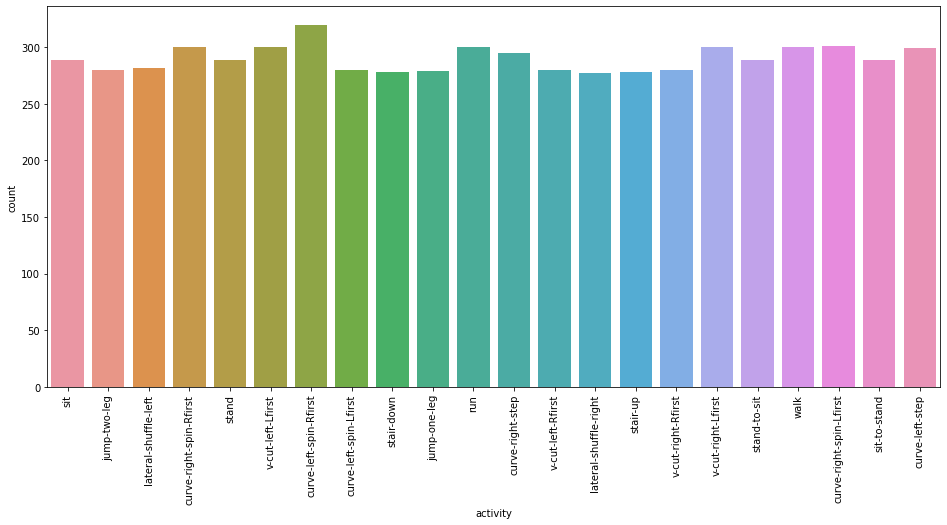

In [740]:
# Count plot for the distribution of different activities in the training dataset
plt.figure(figsize=(16,7))
ax = sns.countplot(x='activity', data=train_df)
plt.xticks(x=train_df['activity'], rotation='vertical')
plt.savefig('images/activities_count.png', dpi=300, bbox_inches='tight')
plt.show()

### Drop "Lay"

In [714]:
train_df.drop(train_df.loc[train_df.activity == 'lay'].index, inplace=True)
pd.crosstab(index=train_df['activity'], columns = 'count')

col_0,count
activity,
curve-left-spin-Lfirst,280
curve-left-spin-Rfirst,320
curve-left-step,299
curve-right-spin-Lfirst,301
curve-right-spin-Rfirst,300
curve-right-step,295
jump-one-leg,279
jump-two-leg,280
lateral-shuffle-left,282


(array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012]),
 [Text(0, 0.0, '0.000'),
  Text(0, 0.002, '0.002'),
  Text(0, 0.004, '0.004'),
  Text(0, 0.006, '0.006'),
  Text(0, 0.008, '0.008'),
  Text(0, 0.01, '0.010'),
  Text(0, 0.012, '0.012')])

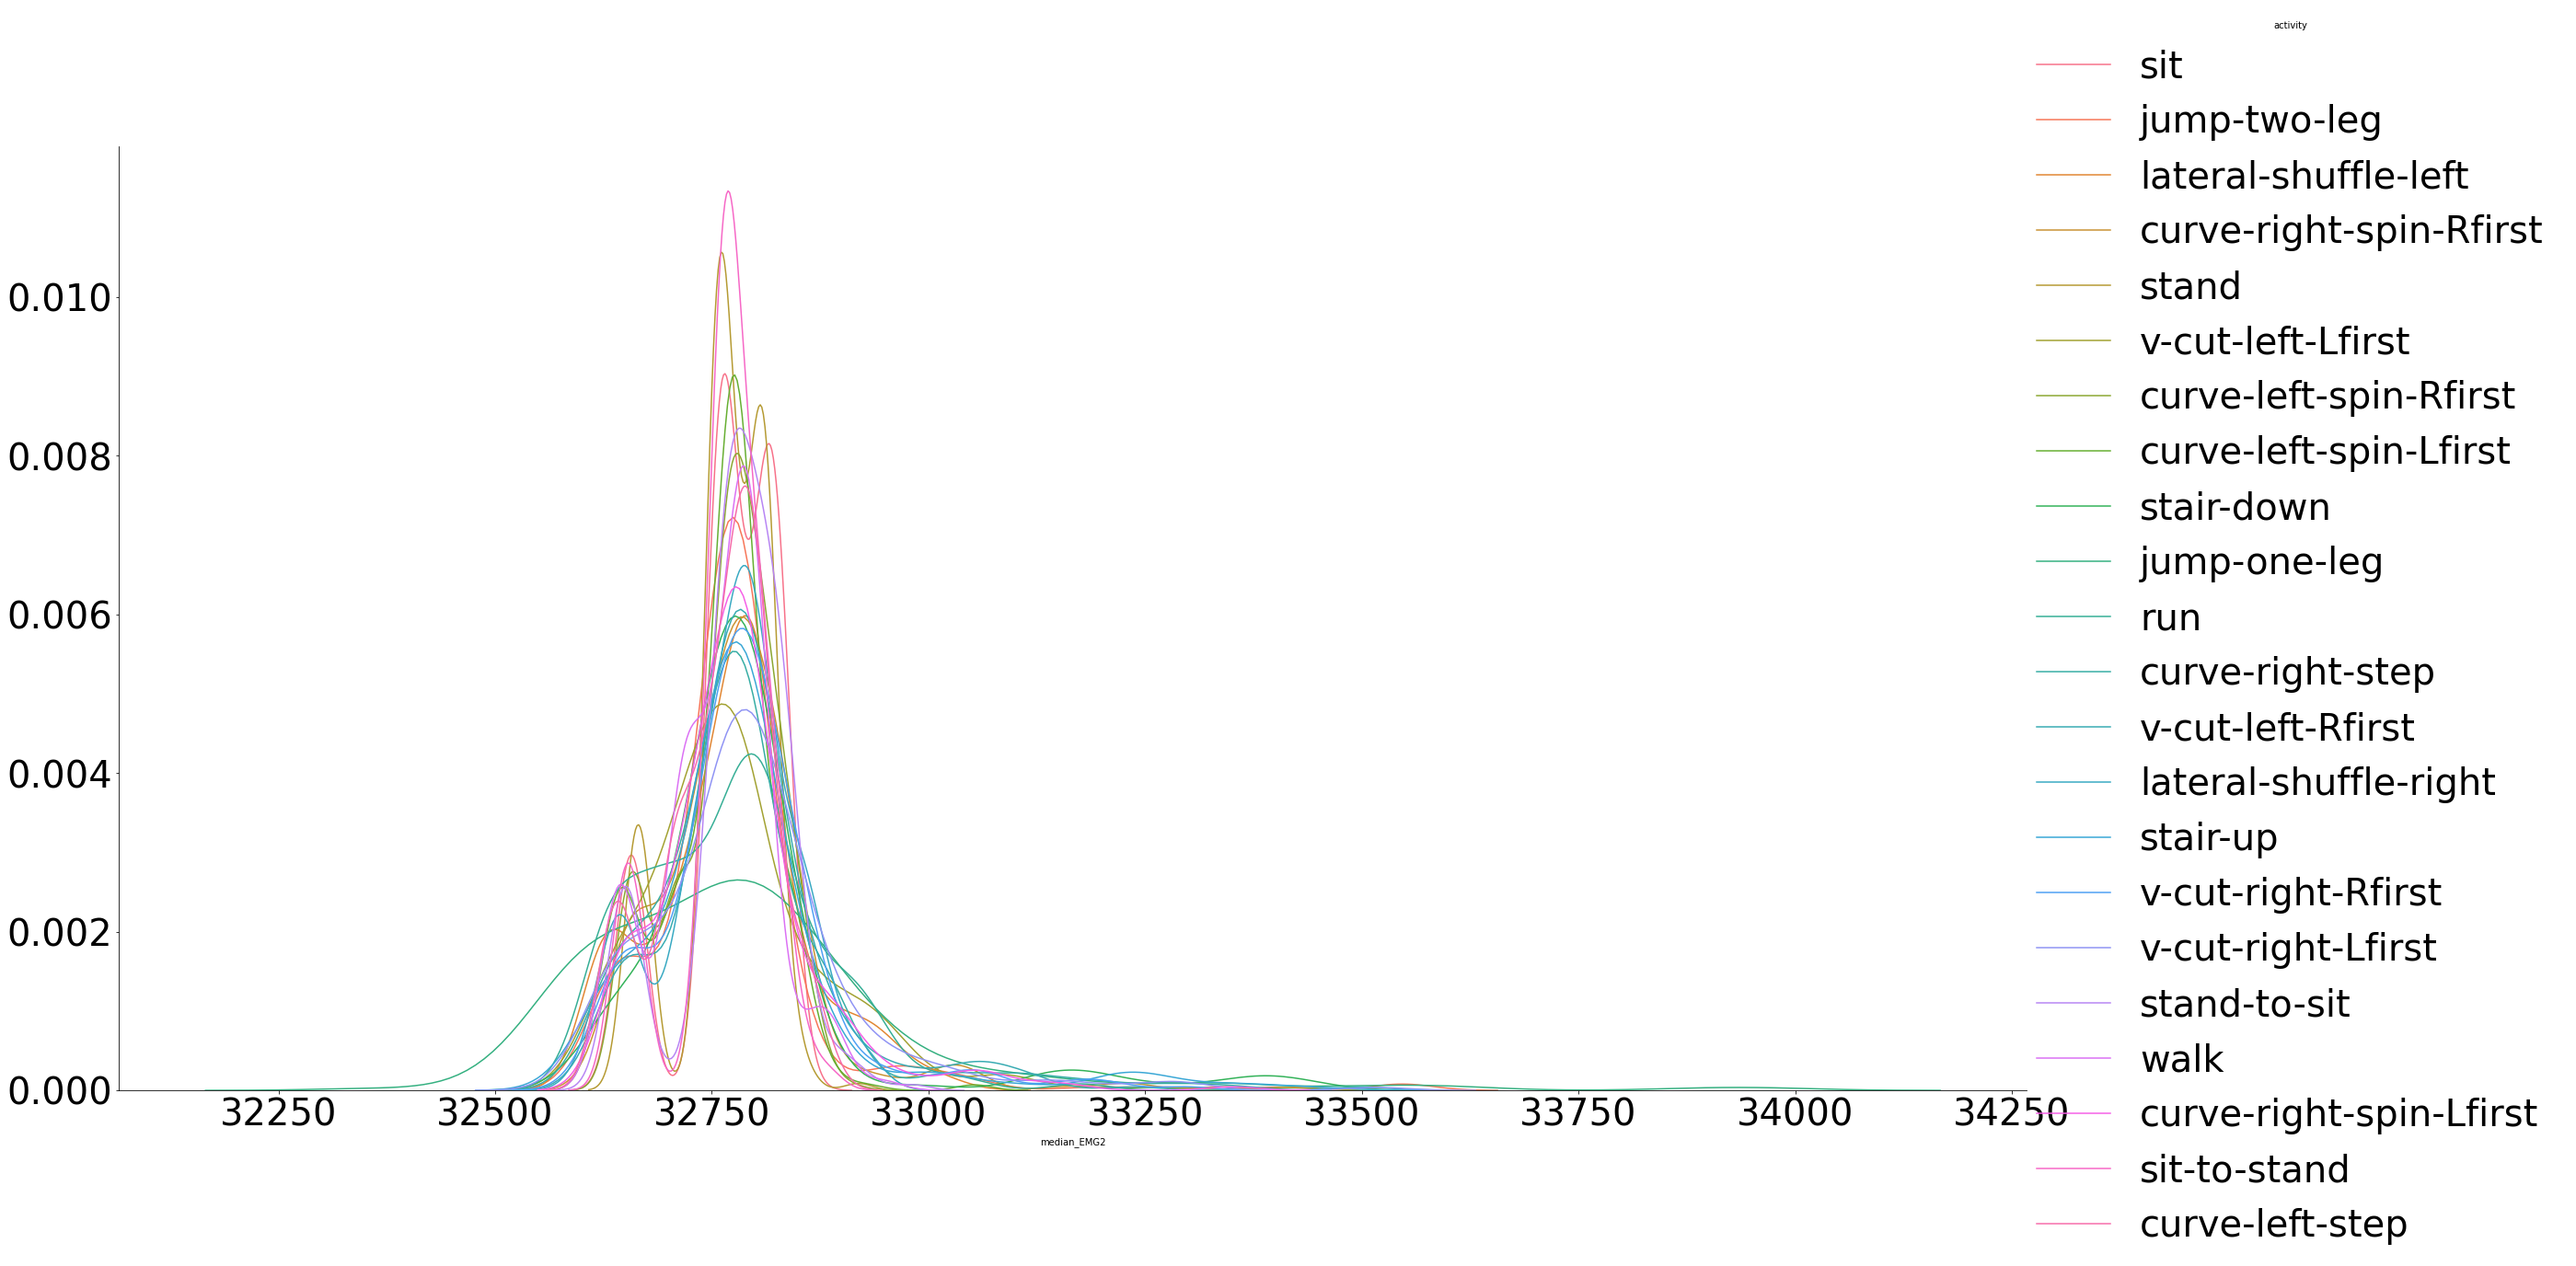

In [715]:
warnings.filterwarnings('ignore')
#fig, ax = plt.plots(figsize=(20,15))
facetgrid = sns.FacetGrid(train_df, hue='activity', height = 15 ,aspect=2)
facetgrid.map(sns.distplot,'median_EMG2', hist=False).add_legend(fontsize=40)
plt.xticks(size=40)
plt.yticks(size=40)

### Histogram for different sensor readings
<p>Look at the second graph i.e Max Airborne. The activities especially 'walk' and 'run' have their mean quite above the 3rd quartile suggesting that the activities are quite fast which makes sense

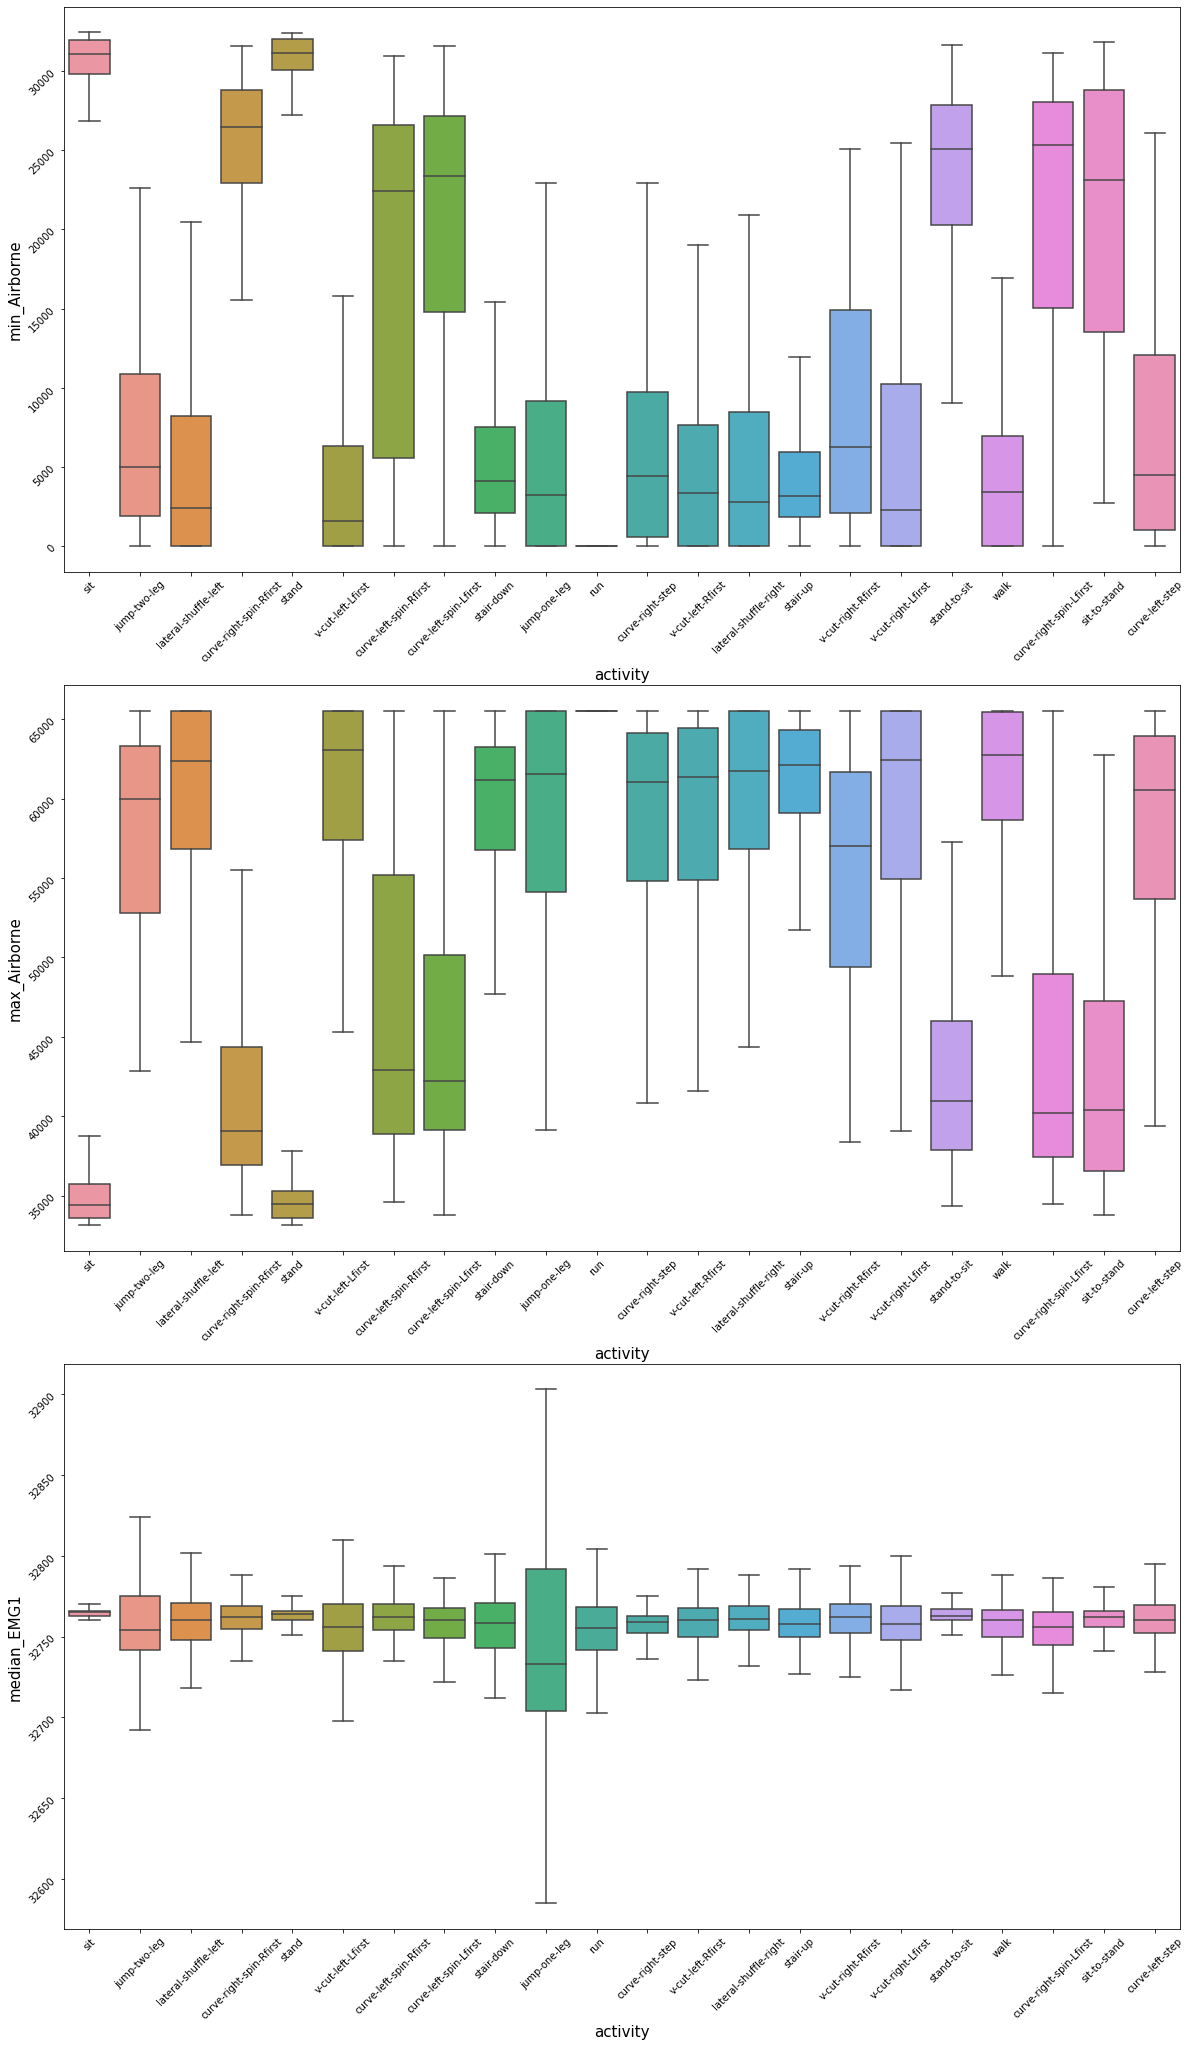

In [716]:
# Histogram for the different sensors
axes = ['ax1', 'ax2', 'ax3']
fig, axes = plt.subplots(3, 1,figsize=(20,15))
plot_type = {'min_Airborne','max_Airborne','median_EMG1'}
for ax, plot in zip(axes, plot_type):
    ax = sns.boxplot(x='activity', y=plot, ax=ax, data=train_df, showfliers=False)
    ax.tick_params(labelrotation=45, labelsize=10)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
plt.subplots_adjust(bottom = -0.9)   
plt.rcParams.update({'axes.titlesize': 'medium'})
plt.show()

### Feature Selection

#### Steps for selecting appropriate features using various techniques:

<ol>
    <li> Check for missing rows/values in the features columns</li>
    <li> Remove features with low variace </li>
    <li> Remove highly correlated features </li>
    <li> Univariate Feature Selection </li>
    <li> Recursive Feature Selection </li>
    <li> Feature selection using SelectFromModel </li>   

In [717]:
# Dividing the dataset into train_X, and train_y
train_X = train_df.drop(columns={'activity'}, axis=1)
print(train_X.shape)


train_y = pd.DataFrame()
train_y['activity'] = train_df.activity # mean_type is just the label with no meaning of 'mean'
print(train_y.shape)

(6385, 190)
(6385, 1)


### Check missing features

In [718]:
# Find missing values in the columns
for i in range(train_X.shape[1]):
    print('Train Dataset : Missing values in the column ' + train_X.columns[i] + ' is',train_X.iloc[:,i].isnull().sum())
for i in range(test_X.shape[1]):
    print('Test Dataset : Missing values in the column ' + test_X.columns[i] + ' is', test_X.iloc[:,i].isnull().sum())

Train Dataset : Missing values in the column mean_ACC lower X is 0
Train Dataset : Missing values in the column mean_ACC lower Y is 0
Train Dataset : Missing values in the column mean_ACC lower Z is 0
Train Dataset : Missing values in the column mean_ACC upper X is 0
Train Dataset : Missing values in the column mean_ACC upper Y is 0
Train Dataset : Missing values in the column mean_ACC upper Z is 0
Train Dataset : Missing values in the column mean_Airborne is 0
Train Dataset : Missing values in the column mean_EMG1 is 0
Train Dataset : Missing values in the column mean_EMG2 is 0
Train Dataset : Missing values in the column mean_EMG3 is 0
Train Dataset : Missing values in the column mean_EMG4 is 0
Train Dataset : Missing values in the column mean_Goniometer X is 0
Train Dataset : Missing values in the column mean_Goniometer Y is 0
Train Dataset : Missing values in the column mean_gyro lower X is 0
Train Dataset : Missing values in the column mean_gyro lower Y is 0
Train Dataset : Missin

### Remove features with correlation higher than a threshold

The dataset can contain variables with multicollinearity and can lead to target variable being significantly affected by it. For more about the effect of multicollinearity, visit the link [ https://medium.com/analytics-vidhya/what-is-multicollinearity-and-how-to-remove-it-413c419de2f ]

Scikit learn link for vif [ https://scikit-learn.org/stable/modules/feature_selection.html#variance-threshold ]

In [719]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = train_X
vif = pd.DataFrame([variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])],
               index=X.columns)
vif['vif_score'] = vif.values
vif_discard = vif[vif.vif_score < 10]



#train_X.drop(columns = vif_discard.index.to_list(), inplace=True)
#test_X.drop(columns = vif_discard.index.to_list(), inplace=True)

#train_X.shape

The vif score gives us only the above features under the (< 10) threshold. Right now we can take this with a pinch of salt and do some more feature selection and see if these features have higher importance or not.

In [720]:
# find and remove correlated features in order to reduce the feature space a bit so that the algorithm takes shorter to find the features

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(train_X, 0.8)
print('correlated features: ', len(set(corr_features)))

correlated features:  136


In [721]:
# remove correlated  features

train_X.drop(columns=corr_features, inplace=True)
test_X.drop(columns=corr_features, inplace=True)

train_X.shape, test_X.shape

((6385, 54), (1738, 54))

### Regularisation
Regularization is a technique used for tuning the function by adding an additional penalty term in the error function. The additional term controls the excessively fluctuating function such that the coefficients don’t take extreme values. This technique of keeping a check or reducing the value of error coefficients are called shrinkage methods or weight decay in case of neural networks.

Source : [ https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea ]

Some regularisation methods:
<ul>
    <li> Ridge Regression </li>
    <li> Lasso Regression </li>
</ul>

For this dataset I will use Lasso Regression method because it is better at removing not so useful features.

In [722]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# This step of standarization is crucial for linear models like lasso
scaler = StandardScaler()
train_X_standardized = scaler.fit_transform(train_X)

# Encode the string labels to numeric

label_encoder = preprocessing.LabelEncoder()
y_train_label_encoded = label_encoder.fit_transform(train_y)

In [723]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

# the lasso regression has a penalty term associated with it (lambda + (slope)^2)

lasso_feature_selection = SelectFromModel(Lasso(alpha=0.005, random_state=0))
lasso_feature_selection.fit(train_X_standardized, y_train_label_encoded)
features_selected = train_X.columns[(lasso_feature_selection.get_support())]
print('Lasso selected features:{}'.format(len(features_selected)))

Lasso selected features:54


In [724]:
# We will use the above selected features for the next step which is RFE

train_X = train_X[features_selected]
test_X = test_X[features_selected]

print(train_X.shape, test_X.shape)

(6385, 54) (1738, 54)


### Recursive Feature Elimination
RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score.

Technically, RFE is a wrapper-style feature selection algorithm that also uses filter-based feature selection internally.

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

Source for the above :[ https://machinelearningmastery.com/rfe-feature-selection-in-python/ ]

RFE can use a number of algorithms at its core like:
<ul> 
    <li>LogisticRegression</li>
    <li>Perceptron</li>
    <li>DecisionTreeClassifier</li>
    <li>RandomForestClassifier</li>
    <li>GradientBoostingClassifier</li>
</ul>

In [725]:
# We will use RandomForest to find the out the feature importances
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Create the RFE object and compute a cross-validated score.
RandomForest_clf = RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features=0.25, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=50, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False)

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=RandomForest_clf, step=20, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(train_X, train_y)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_features=0.25, n_estimators=50),
      scoring='accuracy', step=20)

Optimal Number of features: 34


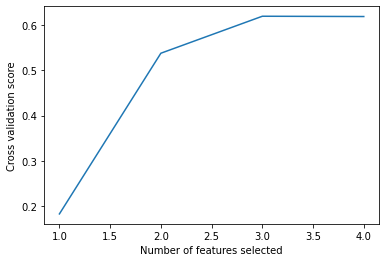

In [726]:
# optimal number of features
print('Optimal Number of features: %d' % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [727]:
sel = SelectFromModel(RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=50, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,
                                                 warm_start=False))
sel.fit(train_X, train_y)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=50))

<AxesSubplot:>

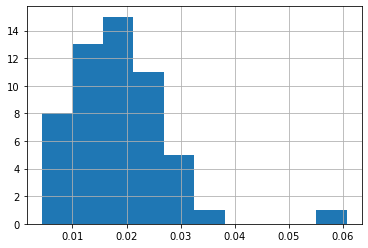

In [728]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [729]:
features_selected = train_X.columns[(sel.get_support())]
print(features_selected)

Index(['mean_ACC upper X', 'mean_ACC upper Y', 'mean_ACC upper Z',
       'mean_Goniometer Y', 'mean_gyro lower X', 'mean_gyro upper Y',
       'mean_gyro upper Z', 'median_gyro lower Y', 'median_gyro upper Z',
       'min_ACC upper Y', 'min_ACC upper Z', 'min_EMG1', 'min_EMG4',
       'min_gyro upper Y', 'min_gyro upper Z', 'max_ACC lower Y',
       'max_ACC upper Z', 'std_ACC upper X', 'std_Airborne',
       'std_Goniometer X', 'std_Goniometer Y', 'variance_ACC upper X',
       'rms_gyro lower Y', 'rms_gyro lower Z', 'pe_gyro lower Y',
       'pe_gyro lower Z', 'pe_gyro upper X'],
      dtype='object')


In [730]:
# Including the features_selected in the traning set and test set
train_X = train_X[features_selected]
test_X = test_X[features_selected]
print(train_X.shape, test_X.shape)

(6385, 27) (1738, 27)


## Pickle the Data 

In [737]:
# Write the new training features, labels and the test to the folder 'after_feature_engg'
file_names = {'train_X':train_X, 'train_y':y_train_label_encoded,'labels':train_y,'test_X':test_X}
for k, file_n in file_names.items():
    output_file_path = r'/Users/rohankumar/Desktop/BBDC 2019/Data/pickle/after_feature_engg/' + k + '.pickle'
    pl = open(output_file_path, 'wb')
    pickle.dump(file_n, pl)

In [739]:
# read the new training features, labels and test data from the folder 'after_feature_engg'
output_file_path = r'/Users/rohankumar/Desktop/BBDC 2019/Data/pickle/after_feature_engg/test_X.pickle'
pl=open(output_file_path, "wb")
pickle.dump(test_X, pl)